In [11]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler, RobustScaler
import HomeMade as hm
import xgboost as xgb

In [111]:
N = 1e5

all_features = "v0_ks_mass v0_ks_massErr ntrk_pv0 pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

feats = "v0_chi2, v0_phi1, v0_py1, v0_py, v0_py2, v0_phi2, v0_px2, v0_px, cosTheta, a0xy, a0, v0_y, v0_x, v0_rxyErr, v0_z, pv0_z, pv0_y, ntrk_pv0, pv0_x".split(", ")

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)].reset_index(drop=True)
# train_test_slice = int(len(mc)*0.8)
# train_mc = mc[:train_test_slice]
# test_mc = mc[train_test_slice:]

In [121]:
scaler = RobustScaler()
mapper = umap.UMAP()
cla = xgb.XGBClassifier()

feats = feats[:3]

data = scaler.fit_transform(mc[feats])

In [132]:
feats

['v0_chi2', 'v0_phi1', 'v0_py1']

In [122]:
cla.fit(data,mc.trueKs)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [ ]:
emb_dat = mapper.fit_transform(data)

In [129]:
d = len(feats)
N_grid = 100
mins = data.min(axis=0)
maxs = data.max(axis=0)
step_sizes = (maxs-mins)/N_grid
string = "np.mgrid["
for i in range(d):
    string += str(mins[i])+":"+str(maxs[i])+":"+str(step_sizes[i])+","
string = string[:-1] + "]"

grid = eval(string)
grid = grid.reshape(d,-1).T
p_grid = cla.predict_proba(grid)[:,1]

In [136]:
len(grid), N_grid**d

(1010000, 1000000)

In [130]:
emb_grid = mapper.transform(grid)

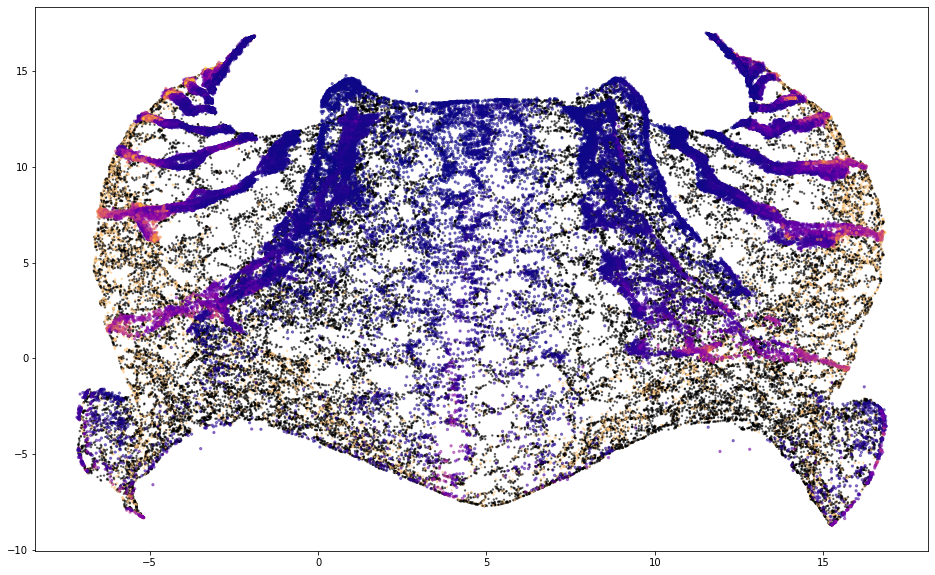

In [133]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(emb_dat[:,0],emb_dat[:,1],s=2,c=mc.trueKs,cmap='copper',alpha=0.5)
ax.scatter(emb_grid[:,0],emb_grid[:,1],s=5,c=p_grid,cmap='plasma',alpha=0.5)

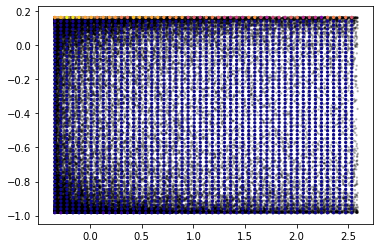

In [110]:
fig, ax = plt.subplots()
ax.scatter(data[:,0],data[:,1],s=2,c=mc.trueKs,cmap='copper',alpha=0.2)
ax.scatter(grid[:,0],grid[:,1],s=5,c=p_grid,cmap='plasma')
# ax.contour(grid[:,0],grid[:,1],p_grid.reshape(20,20))